# 0 Installing required packages

In [ ]:
# %pip install pandas
# %pip install pyarrow
# %pip install numpy
# %pip install scikit-learn
# %pip install imbalanced-learn
# %pip install matplotlib

#  1 Preparing data

Before a model can even be trained; it requires data. But there are steps needed to ensure that the data is cleaned and ready for a model - if the data is wrongly formatted or missing; the model training process will not work. Thus, the following steps are advised.

## 1.1 Reading Data

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_parquet('catB_train.parquet')

## 1.2 Processing Data

In [ ]:
# Convert target col to 0 or 1
df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)

# Identifiy numeric columns and fill null values with the median value
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Drop non-numeric cols
non_numeric_cols = df.select_dtypes(include=["string", "object"]).columns
df = df.drop(columns=non_numeric_cols)

y = df["f_purchase_lh"]
X = df.drop(columns=['f_purchase_lh'])

## 1.3 Applying SMOTE (Synthetic Minority Oversampling Technique)

When dealing with a dataset with unbalanced target variable (for example, many normal emails and few spam emails), we may apply SMOTE to generate more of the minority class, so we can train models to catch positive cases more effectively.

Besides SMOTE, there are many more algorithms and methods one can use to solve the problem. Dive deeper with these articles:
1. https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
2. https://imbalanced-learn.org/stable/over_sampling.html

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

print('Before:', Counter(y_train))
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print('After:', Counter(y_train))

# 2. Modelling and Evaluation

After completing the previous stages of the workflow discussed, we are finally ready totrain models and evaluate their performance. In this section, we explore some metrics to evaluate performance, to help us decide if we have a satisfactory model or not. This is usually evaluated against a hold-out set of data.

## 2.1 Metrics

In machine learning, there are many metrics we can use to evaluate model performance. We decide the metric to use depending on the nature of the problem (classification vs regression).

For classification context, here are some metrics we can use:
1. Accuracy
2. Precision
3. Recall
4. F-score, or F1-score (Calculated from Precision and Recall)

Dive deeper:
1. https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
2. https://www.statology.org/sklearn-classification-report/

## 2.2 Cross-validation (the 80-20 train-test split)

Cross validation is used to evaluate your model's performance, giving insight on the cases where your model performs well and where it falls short.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Decision Tree model (more explanation for this in Modelling Section)
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Evaluate on validation set
y_val_pred = dt_clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,) # set display_label according to dataset
disp.plot()

## 2.3 K-fold Cross-validation (80-20 split 'cycling through entire dataset')

In practice, we use K-fold cross-validation for hyperparameter tuning. Hyperparameter tuning is the act of finding the best model parameters (what parameters can be varied depends on the type of model you are using).

We will not go into further detail in this workshop, to read more about this process and other possible variantions you may refer to the reference document:
https://scikit-learn.org/stable/modules/cross_validation.html

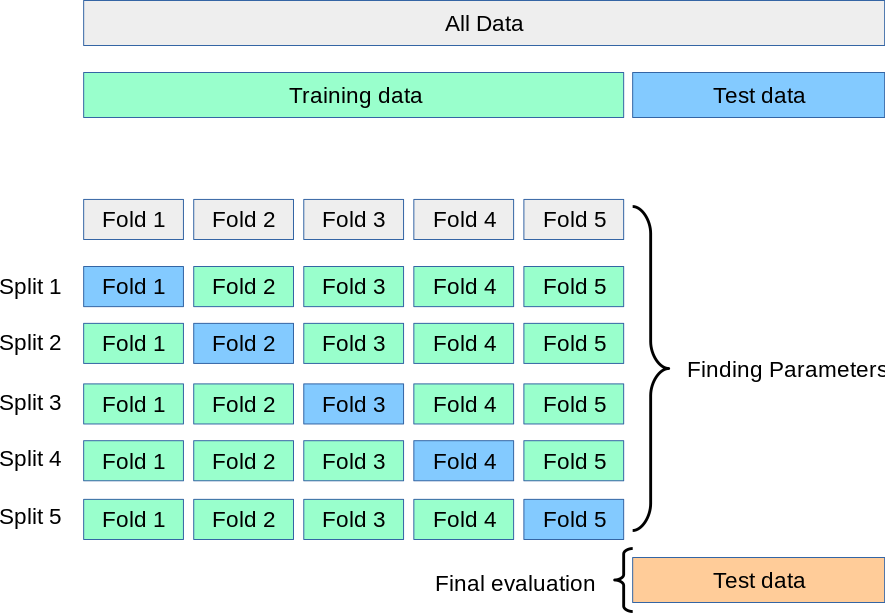

Sample Code:

In [ ]:
from sklearn.model_selection import cross_val_score

model = dt_clf
scores = cross_val_score(model, X, y, cv=5)

# By default, cross_val_score returns a numpy array of accurcacies for each train-test split
#>>> scores
#array([0.96..., 1. , 0.96..., 0.96..., 1. ])

# To use other metrics for example, f1-macro score:
from sklearn import metrics

scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
scores

**Futher considerations for cross-validation:**

Imbalanced dataset? Stratification of each split (to ensure each split is balanced to reduce overfitting, by reducing data imbalance in each split)


For a deeper dive, refer to these articles:
1. https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/
2. https://neptune.ai/blog/cross-validation-mistakes

# 3. Introduction to Machine Learning models


## 3.1 No Free Lunch Theorem
In this section, we will explore several classic and important models in the field of machine learning. The first question that comes to mind would be: what is the best machine learning model? Is there a model that can accurately solve all problems? As it turns out, in  the late 20th century, mathematicians proved that such a model does not exist. If you're interested to learn more about this theorem, check out https://machinelearningmastery.com/no-free-lunch-theorem-for-machine-learning/.

TLDR: The moral of the story is that different machine learning models are required in different situations. Some models may outperform others for a specific problem, but perform worse in another problem.

## 3.2 K-Nearest Neighbours

One of the most natural (and naive) way to model a classification problem is to leverage the idea of a majority vote. For instance, suppose we have a set of 5 training examples with their corresponding labels, say $\{(X_1, 0), (X_2, 0), (X_3, 1), (X_4, 1), (X_5, 0)\}$. Now, if we have a new example, say $X$, that we wish to classify, we can first find the 3 examples that are closest to $X$. Let's say those examples turn out to be $\{X_1, X_3, X_5\}$. Then, from our given information, we know that $X_1$ and $X_5$ are from class 0 and $X_3$ is from class 1. That means, by a majority vote, our new example $X$ should be classified as class 0.

The K-Nearest Neighbours model is built on this idea. In fact, the idea is so simple that you could build this model from scratch on your own. The tricky bits lie in the computation of all these distances when you have a large number of training examples or a large number of rows in each example. There are various algorithms that have been designed to optimise this process while maintaining a good performance. Feel free to read more about it at: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html



In [ ]:
# import the necessary class from the scikit-learn library
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# assume X_train, y_train are df/numpy objects
knn_clf = KNeighborsClassifier(n_neighbors=2)
knn_clf.fit(X_train, y_train)
print("train accuracy: ", knn_clf.score(X_train, y_train))
print("val accuracy: ", knn_clf.score(X_val, y_val))

## 3.2 (a) Decision Tree

Another approach to this binary classification problem is to apply the Decision Tree model. As the name suggest, the Decision Tree model is a model that is built on a series of decisions. A good way to think about these decisions is to view them as an if-else statement. Here's a simple example that motivates the idea of using a decision.

Hypothetically, suppose that in our dataset, we observed that age is a factor that influences the person's decision to purchase insurance. Then, a logical approach could be to attempt to predict a person's decision based on their age. Suppose after looking through all the training data, you realise that 90% of people above the age of 50 would purchase insurance. With such a high success rate of predicting a person's decision, you decide to use `age = 50` as a threshold. However, there's no reason to stop there. You could potentially ask more questions. Perhaps a person's gender or occupation could be factors that can help you further categorise the examples, yielding even more accurate predictions.

Once you recursively repeat this thresholding process for selected factors, you'll get a series of if-else statements that essentially form a tree. Some of you might notice a few caveats in this approach:


1. How do we know which factors to pick?
2. How can we find the optimal threshold for a given factor?
3. In what order should I pick the factors?

These are all really intresting questions that have been considered and taken into account to by the Scikit-learn package that we are using. If you're interested to learn more, feel free to check out: https://www.geeksforgeeks.org/decision-tree/



In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
print("train accuracy: ", dt_clf.score(X_train, y_train))
print("val accuracy: ", dt_clf.score(X_val, y_val))

## 3.2(b) Random Forest

After thinking about the Decision Tree approach, some questions spring up naturally:


1. Are there alternate ways to form the Decision Tree and yield a comparable performance?
2. How generalisable is the Decision Tree? How can we improve the generalisability of this model?

As it turns out, the answer to these questions led to the idea of a Random Forest model. The idea is simple. Take multiple random samples from the training data and train a new Decision Tree for each sample. Then, when performing the final prediction, make a prediction with each model and use the majority vote as the final prediction.

There are some other nuances in the implementation to further increase the performance of the Random Forest model. If you're interested to learn more, check out: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rndforest_clf = RandomForestClassifier()
rndforest_clf.fit(X_train, y_train)
print("train accuracy: ", rndforest_clf.score(X_train, y_train))
print("val accuracy: ", rndforest_clf.score(X_val, y_val))

## 3.2(c) Gradient Boosting

Another variant of the Decision Tree model is to introduce gradient boosting. The idea behind gradient boosting is construct a large number of decision trees with depth 1 (i.e. by asking only one question) and making a prediction by taking the weighted average of each tree's prediction. This is done to reduce the problem of overfitting.

To check out more about gradient boosted trees, go to: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier

There is also another Python package, known as XGBoost, which can create highly optimised gradient boosted decision trees. Feel free to check them out: https://xgboost.readthedocs.io/en/stable/

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
boosted_clf = GradientBoostingClassifier()
boosted_clf.fit(X_train, y_train)
print("train accuracy: ", boosted_clf.score(X_train, y_train))
print("val accuracy: ", boosted_clf.score(X_val, y_val))

## 3.3 Support Vector Machine

A good way to motivate the idea for a Support Vector Machine model is to consider the following problem:

Suppose you have a set of points in space, where each of them belongs to one of two categories. Your goal is to draw boundary such to correctly classify these points while ensuring that the boundary is as far as possible from each point. In 2D space, as seen in the figure below, that could be achived by drawing a straight line or a curve and using that as a boundary. In this case, we shall restrict ourselves to using only linear boundaries, i.e. drawing a straight line.

<div>
<img src="https://drive.google.com/uc?id=1ecZVxRqCpNzDVrGH5cyMFBKxkWsmLTRR" width="500"/>
</div>


This is one half of the idea. The other half is to address the assumption of using a linear decision boundary. As it turns out, it has been proven that for any set of points, we can find some mathematical function to project it into higher dimensional space and find a linear boundary in this space to separate the points.

<div>
<img src="https://drive.google.com/uc?id=18vwSD0ElQ9D8b0OiyDMbNkUMLwiXtH70" width="300"/>
<img src="https://drive.google.com/uc?id=1W5OC1xDTVwvAGgRFjqlPhK553kTOabS2" width="300"/>
<img src="https://drive.google.com/uc?id=1XKymTBvLQawUyU31qkiQZ5W4doH5RUWk" width="300"/>
</div>
Credits: <a href=https://www.youtube.com/watch?v=Q7vT0--5VII>Visually Explained </a>

As such, putting these two ideas, training a SVM model is essentially the process of trying to find a decision boundary that is as far as possible from each point in a higher dimensional space.

To learn more about SVMs: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_clf = SVC(C=1)
svm_clf.fit(X_train, y_train)
print("train accuracy: ", svm_clf.score(X_train, y_train))
print("val accuracy: ", svm_clf.score(X_val, y_val))

## 3.4 Logistic Regression

A logistic model is based on a mathematical function that restricts all values to a range that is between 0 and 1. More specifically, a logistic model typically uses a sigmoid function, given by
$$ f(x) = \frac{1}{1 + e^{-x}}. $$
You can plot out this function on your own to see how it looks like.

Intuitively, it makes sense to apply a mathematical function like this to a binary classification problem. To make a prediction in our context, suppose we have an example given by the vector $X$ and another vector called $W$. Then, we would compute $X \cdot W$ (dot product) to get a single scalar value. We can then use that value to make a prediction with the sigmoid function, where the prediction is given as
$$ \frac{1}{1 + e^{-X \cdot W}}. $$

As such, when training the model, we are essentially trying to optimise $W$ to our training data, such that the prediction made using $W$ is as close to our training labels as possible. This training process is taken care of by built-in libraries like Scikit-Learn.

To learn more about logistic regression models, check out: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
print("train accuracy: ", log_clf.score(X_train, y_train))
print("val accuracy: ", log_clf.score(X_val, y_val))

# 3.5 Neural Networks

From a certain point of view, a neural network can be thought of as a generalisation of a logistic regression model. Recall that in a logistic regression model, if you have a vector $X = (x_1, x_2, \dots, x_n)$ and a weight vector $W = (w_1, w_2, \dots, w_n)$, the model prediction is then given by $f(X \cdot W)$, where
$$ f(x) = \frac{1}{1 + e^{-x}}. $$
One observation made from the logistic regression model is that its modelling ability my be restricted by the fact that $X \cdot W = x_1w_1 + x_2w_2 + \cdots + x_nw_n$ is a linear function. As it turns out, neural networks can be used to overcome this limitation by allowing the model to learn much more complicated patterns before passing the final scalar value into the sigmoid function, $f(x)$.

To learn more about neural networks, 3Blue1Brown has amazing videos that explains and visualise neural networks: https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=kgjauvGPmEtbT_F7

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
nn_clf = MLPClassifier()
nn_clf.fit(X_train, y_train)
print("train accuracy: ", nn_clf.score(X_train, y_train))
print("val accuracy: ", nn_clf.score(X_val, y_val))

Scikit-learn provides a neural network model which has the same interface as all the previous models that we have encountered. The benefits of using the Scikit-learn implementation is the simplicity that the library provides. However, in general, to create more powerful neural network models, libraries like TensorFlow and PyTorch are used.

TensorFlow: https://www.tensorflow.org/tutorials/quickstart/beginner

PyTorch: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html